Author: Jonathan Gong

In [10]:
import pandas as pd
import os
import sys
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from hmmlearn.hmm import GaussianHMM


# Data processing

##### Data Loading

In [2]:
# Load one of the CSV files to inspect its columns
sample_file = pd.read_csv('../data/raw/500030_2024-07-01_2024-09-30.csv')


In [3]:
csv_files = []
for file in os.listdir('../data/raw'):
    if file.endswith('.csv'):
        csv_files.append(pd.read_csv(f'../data/raw/{file}', dtype={'template': 'str'}))

#### Data Processing

In [28]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

def dataprocessing(csv_files, target_day=None):
    # Extract the date, bgl, and msg_type columns from each CSV file
    each_bgl = []
    for file in csv_files:
        each_df = file[["date", "bgl", "msg_type"]]
        each_df["date"] = pd.to_datetime(each_df["date"], format='%Y-%m-%d %H:%M:%S%z', errors='coerce', utc=True)
        each_df['date'] = each_df['date'].fillna(method='ffill')
        each_df['bgl'] = each_df['bgl'].fillna(method='ffill')
        each_df["msg_type"] = [
            1 if i == 'INTERVENTION_SNACK' else 2 if i == 'ANNOUNCE_MEAL' else 0
            for i in each_df["msg_type"]
        ]
        each_df = each_df.sort_values('date')

        # Filter by specific day if target_day is provided
        if target_day:
            each_df = each_df[each_df['date'].dt.date == pd.to_datetime(target_day).date()]

        each_bgl.append(each_df)

    # Extract the date, time, and day columns from each df and split them into separate days
    days_patients = []
    for bgl in each_bgl:
        # (hour:minute:second)
        bgl['time'] = bgl['date'].dt.time
        # (year-month-day)
        bgl['day'] = bgl['date'].dt.date
        
        # Here, we're only interested in the data for the specific day
        unique_days = bgl['day'].unique()
        day_data = []
        
        for day in unique_days:
            # Filter data for the day
            bgl_day = bgl[bgl['day'] == day]
            day_data.append(bgl_day[["date", "bgl"]])

        days_patients.append(day_data)

    # set index to date
    for patient_days in days_patients:
        for df in patient_days:
            df.set_index('date', inplace=True)

    # Scale BGL data
    patients_scaled = []
    scaler = StandardScaler()
    for patient_days in days_patients:
        # Only scale data if there's data available for that day
        if len(patient_days) > 0:
            scaled_data = scaler.fit_transform(pd.concat(patient_days))
            patients_scaled.append(scaled_data)

    # Make ground truth labels for BGL data
    patients_labels = []
    for bgl in each_bgl:
        # Only append labels for rows corresponding to the specific day
        labels = bgl[["date", "msg_type"]]
        if target_day:
            labels = labels[labels['date'].dt.date == pd.to_datetime(target_day).date()]
        patients_labels.append(labels)

    return days_patients, patients_scaled, patients_labels


# Model

In [11]:
from sklearn.mixture import GaussianMixture
from hmmlearn.hmm import GaussianHMM
import numpy as np
from sklearn.cluster import KMeans

def runGMMHMM(supervised, X, n_components, n_mix, n_iter, Y=None):
    # Step 1: Initialize GMM using KMeans for component initialization
    data_used = X
    kmeans = KMeans(n_clusters=n_components).fit(data_used)
    initial_means = kmeans.cluster_centers_

    # Step 2: Fit GMM to data
    gmm = GaussianMixture(n_components=n_mix, covariance_type='full', max_iter=n_iter)
    gmm.means_ = initial_means
    gmm.fit(X)

    # Step 3: Initialize HMM
    hmm = GaussianHMM(n_components=n_components, covariance_type='full', n_iter=n_iter, verbose=True)

    if not supervised:
        # Unsupervised: Fit HMM without labels
        hmm.startprob_ = np.full(n_components, 1.0 / n_components)
        hmm.transmat_ = np.full((n_components, n_components), 1.0 / n_components)
        hmm.means_ = gmm.means_
        hmm.covars_ = gmm.covariances_
        hmm.fit(X)
        return hmm

    # Supervised: Fit HMM with labels
    if Y is None:
        raise ValueError("Supervised training requires labels (Y).")
    
    hmm.startprob_ = np.full(n_components, 1.0 / n_components)
    hmm.transmat_ = np.full((n_components, n_components), 1.0 / n_components)
    hmm.means_ = gmm.means_
    hmm.covars_ = gmm.covariances_
    hmm.fit(X)
    
    # Predict hidden states with the trained HMM
    hidden_states = hmm.predict(X)
    return hmm, hidden_states


# Run

In [30]:
# Suppose you want to process data for '2024-08-15'
target_day = '2024-08-15'
days_patients, patients_scaled, patients_labels = dataprocessing(csv_files, target_day=target_day)


C:\Users\Nathan\AppData\Local\Temp\ipykernel_16356\1660531715.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  each_df["date"] = pd.to_datetime(each_df["date"], format='%Y-%m-%d %H:%M:%S%z', errors='coerce', utc=True)
C:\Users\Nathan\AppData\Local\Temp\ipykernel_16356\1660531715.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  each_df['date'] = each_df['date'].fillna(method='ffill')
C:\Users\Nathan\AppData\Local\Temp\ipykernel_16356\1660531715.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [31]:
all_days_patient_0 = pd.concat(days_patients[0])
all_days_patient_1 = pd.concat(days_patients[1])

In [32]:
n_components = 3
model = runGMMHMM(supervised= False, n_components=n_components, X = all_days_patient_0, n_mix = 2, n_iter = 100)


c:\Users\Nathan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Nathan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


c:\Users\Nathan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
         1   -2452.80563332             +nan
         2   -2164.36915250    +288.43648083
         3   -2053.76122535    +110.60792714
         4   -2009.54117348     +44.22005187
         5   -2006.14934801      +3.39182547
         6   -2005.69675028      +0.45259774
         7   -2005.57687891      +0.11987137
         8   -2005.53883320      +0.03804571
         9   -2005.52559099      +0.01324221
        10   -2005.52071798      +0.00487301


In [33]:
from scipy.ndimage import gaussian_filter1d

test_data = all_days_patient_0
test_smoothed = gaussian_filter1d(all_days_patient_0, sigma=15)

hidden_states = model.predict(test_smoothed.reshape(-1, 1))


In [34]:
np.unique(hidden_states) #im gna kill myself please for the love of god be smth different

array([0, 1, 2], dtype=int64)

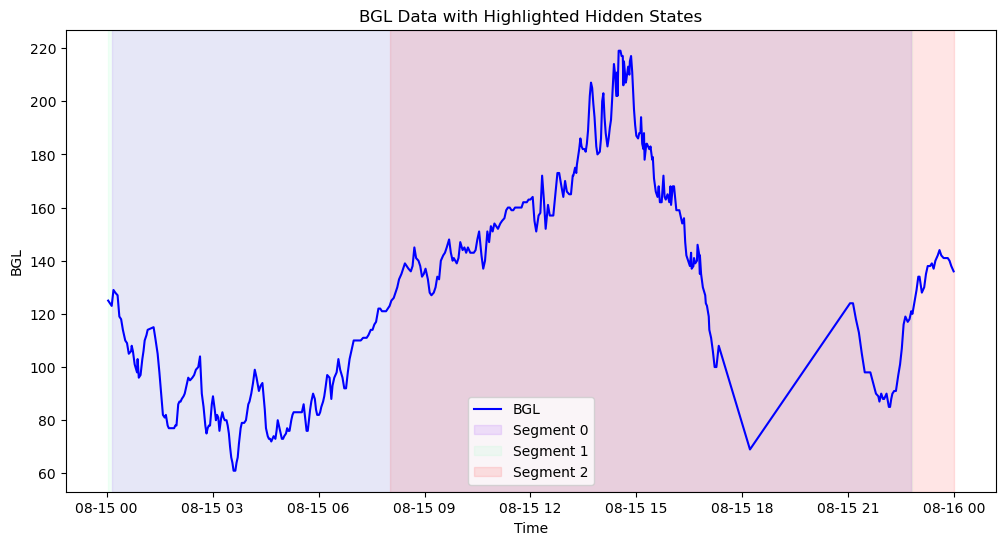

In [35]:
import matplotlib.pyplot as plt

# Create a figure and axis
plt.figure(figsize=(12, 6))

# Convert numpy array back to DataFrame
bruh = pd.DataFrame(test_smoothed, index=test_data.index, columns=['bgl'])

bruh = all_days_patient_0
# Plot the BGL data
plt.plot(bruh.index, bruh["bgl"], label='BGL', color='blue')

# Highlight segments based on hidden states
unique_segments = np.unique(hidden_states)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_segments)))

for segment, color in zip(unique_segments, colors):
    masks = hidden_states == segment
    segment_indices = bruh.index[masks] 
    plt.axvspan(segment_indices.min(), segment_indices.max(),
                alpha=0.1, color=color, label=f'Segment {segment}')

# Add title and labels
plt.title("BGL Data with Highlighted Hidden States")
plt.xlabel("Time")
plt.ylabel("BGL")
plt.legend()
plt.show()

In [18]:
num_instances = 500

In [19]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(categories='auto', sparse_output=False)
Y_0 = encoder.fit_transform(patients_labels[0][0:num_instances])

In [21]:
n_components = 3
model = runGMMHMM(supervised= True, n_components=n_components, X = all_days_patient_0[0:num_instances], n_mix = 3, n_iter = 100, Y = Y_0)

c:\Users\Nathan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Nathan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


c:\Users\Nathan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
         1   -2426.15400209             +nan
         2   -2217.49341760    +208.66058449
         3   -2150.56525841     +66.92815919
         4   -2131.88938699     +18.67587142
         5   -2128.50991702      +3.37946997
         6   -2127.32518092      +1.18473609
         7   -2126.16344456      +1.16173636
         8   -2124.47662031      +1.68682425
         9   -2121.24053462      +3.23608569
        10   -2113.88186497      +7.35866964
        11   -2098.63223077     +15.24963420
        12   -2067.89285188     +30.73937889
        13   -2012.04496923     +55.84788265
  

In [27]:
hidden_states = model.predict(all_days_patient_0[0:num_instances])

AttributeError: 'tuple' object has no attribute 'predict'

In [25]:
np.unique(hidden_states)

array([0, 1, 2], dtype=int64)

In [ ]:
# gt_labels_0 = patients_labels[0]["msg_type"][0:num_instances]

In [ ]:
gt_labels_0 = patients_labels[0][0:num_instances]

500


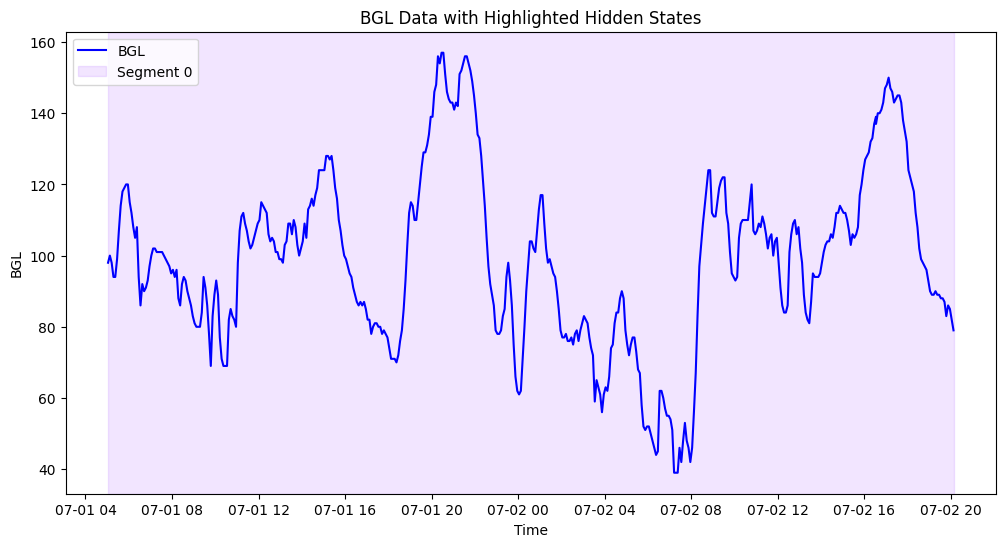

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis
plt.figure(figsize=(12, 6))


bruh = all_days_patient_0[0:num_instances]
# Plot the BGL data
plt.plot(bruh.index, bruh["bgl"], label='BGL', color='blue')

# Highlight segments based on hidden states
unique_segments = np.unique(hidden_states)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_segments)))

for segment, color in zip(unique_segments, colors):
    masks = hidden_states == segment
    print(len(masks))
    segment_indices = bruh.index[masks] 
    plt.axvspan(segment_indices.min(), segment_indices.max(),
                alpha=0.1, color=color, label=f'Segment {segment}')

unique_labels = [1, 2]
label_colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

# for segment, color in zip(unique_labels, label_colors):
#     masks = gt_labels_0["msg_type"] == segment
#     print(len(masks))
#     segment_indices = gt_labels_0["date"][masks].to_numpy()
#     print(segment_indices)
#     plt.axvline(segment_indices, color=color, label=f'Segment {segment}')
# masks = gt_labels_0 == 1
# gt_labels_0[masks]
# plt.plot(bruh.index, gt_labels_0[gt_labels_0 == 1], label='gt', color='red')

# Add title and labels
plt.title("BGL Data with Highlighted Hidden States")
plt.xlabel("Time")
plt.ylabel("BGL")
plt.legend()
plt.show()

## Proof that the model doesn't work

This is the example from the sktime documentation for GMMHMM

In [ ]:
from sktime.annotation.hmm_learn import GMMHMM 
from sktime.annotation.datagen import piecewise_normal
data = piecewise_normal( 
   means=[2, 4, 1], lengths=[10, 35, 40], random_state=7
   ).reshape((-1, 1))
model = GMMHMM(n_components=3) 
model = model.fit(data) 
labeled_data = model.predict(data)


Model is not converging.  Current: -148.93645808846873 is not greater than -85.22299288996437. Delta is -63.71346519850435


In [ ]:
np.unique(labeled_data)

array([0])

Using both unsupervised and supervised methods with many preprocessing techniques such as normalization, scaling, smoothing, and further hyperparameter tuning of the model did not produce any results. Thus the GMMHMM is not recommended for our use